In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [128]:
road_profile_0 = pd.read_csv("data/útprofil_X_bal.csv", sep=';')

In [129]:
road_profile_0['Z']

0      0.0000
1     -0.0177
2     -0.0031
3     -0.0056
4     -0.0004
        ...  
143   -0.0053
144    0.0045
145    0.0047
146    0.0096
147    0.0186
Name: Z, Length: 148, dtype: float64

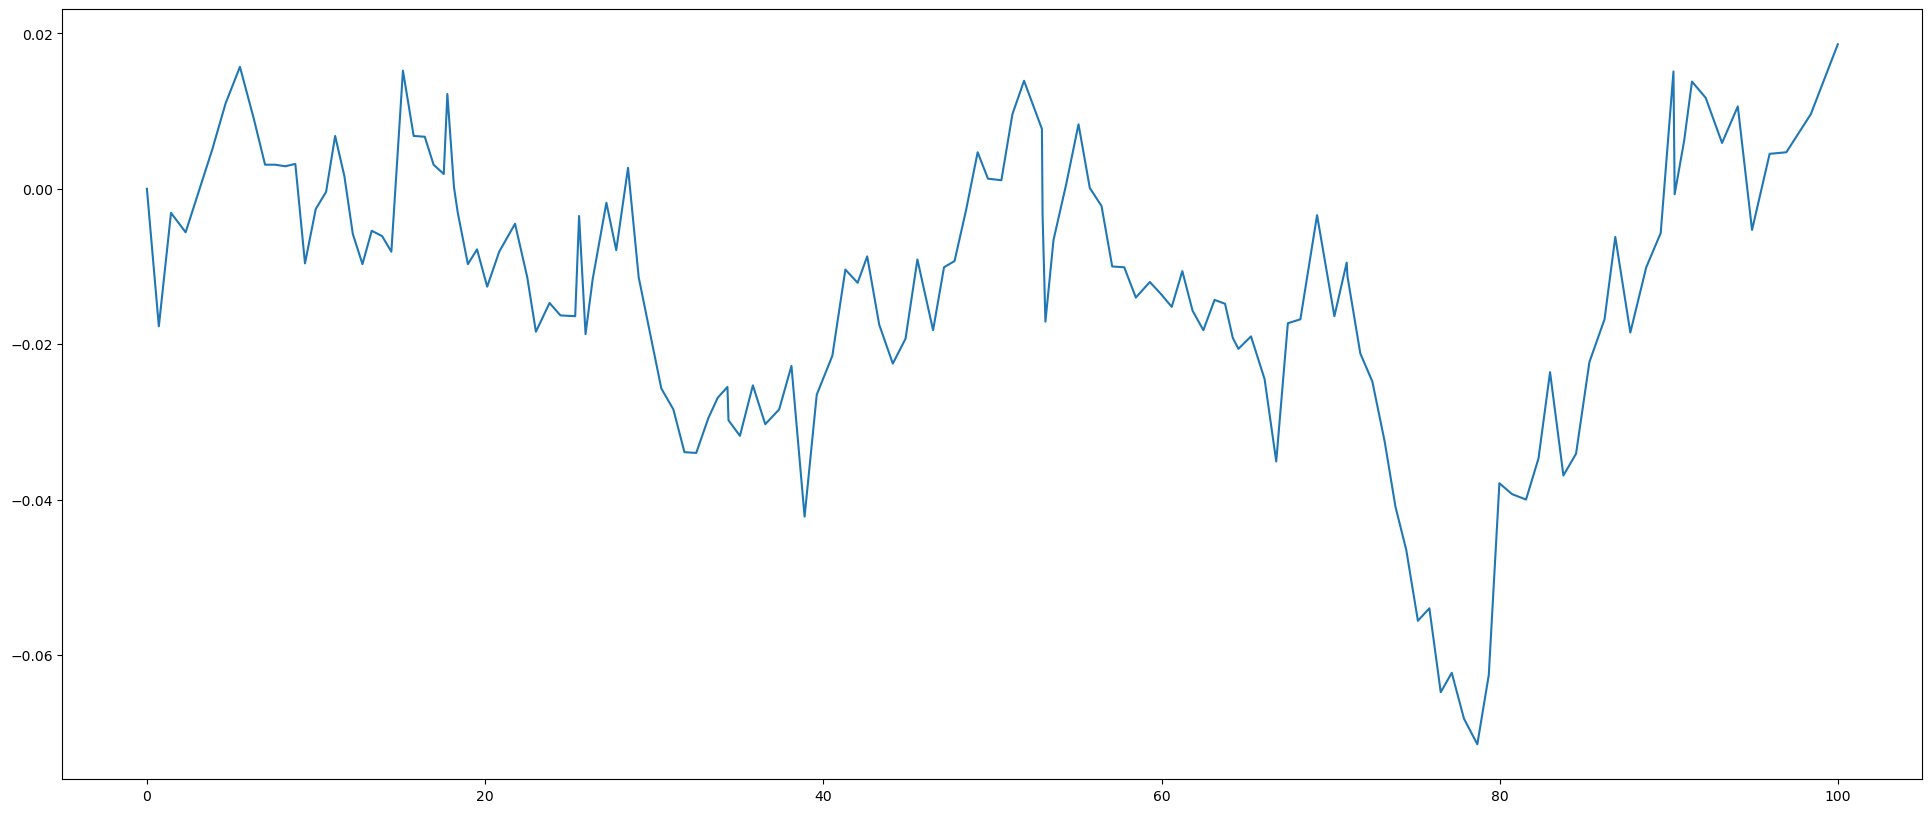

In [130]:
plt.figure(figsize=(24,10))
plt.plot(road_profile_0['X'], road_profile_0['Z'])

In [131]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [132]:
lookback = 4
X_train, y_train = create_dataset(road_profile_0['Z'].to_numpy(), lookback)

In [133]:
X_train

tensor([[ 0.0000e+00, -1.7700e-02, -3.1000e-03, -5.6000e-03],
        [-1.7700e-02, -3.1000e-03, -5.6000e-03, -4.0000e-04],
        [-3.1000e-03, -5.6000e-03, -4.0000e-04,  5.0000e-03],
        [-5.6000e-03, -4.0000e-04,  5.0000e-03,  1.1000e-02],
        [-4.0000e-04,  5.0000e-03,  1.1000e-02,  1.5700e-02],
        [ 5.0000e-03,  1.1000e-02,  1.5700e-02,  9.1000e-03],
        [ 1.1000e-02,  1.5700e-02,  9.1000e-03,  3.1000e-03],
        [ 1.5700e-02,  9.1000e-03,  3.1000e-03,  3.1000e-03],
        [ 9.1000e-03,  3.1000e-03,  3.1000e-03,  2.9000e-03],
        [ 3.1000e-03,  3.1000e-03,  2.9000e-03,  3.2000e-03],
        [ 3.1000e-03,  2.9000e-03,  3.2000e-03, -9.6000e-03],
        [ 2.9000e-03,  3.2000e-03, -9.6000e-03, -2.6000e-03],
        [ 3.2000e-03, -9.6000e-03, -2.6000e-03, -4.0000e-04],
        [-9.6000e-03, -2.6000e-03, -4.0000e-04,  6.8000e-03],
        [-2.6000e-03, -4.0000e-04,  6.8000e-03,  1.6000e-03],
        [-4.0000e-04,  6.8000e-03,  1.6000e-03, -5.8000e-03],
        

In [134]:
class RoadProfileModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.__cnt_hidden_layers = 50
        self._lstm = nn.LSTM(input_size=4, hidden_size=self.__cnt_hidden_layers, num_layers=1, batch_first=True)
        self._linear = nn.Linear(self.__cnt_hidden_layers, 1)
        
    def forward(self, x):
        h_t = torch.zeros(1,  self.__cnt_hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(1,  self.__cnt_hidden_layers, dtype=torch.float32)
        x, _ = self._lstm(x, (h_t, c_t))
        x = self._linear(x)
        return x

In [135]:
model = RoadProfileModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.08)
loss_fn = nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [136]:
n_epochs=2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch: {epoch}, RMSE: {train_rmse}")

d:\dev\envs\hakiko\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8, 4])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\dev\envs\hakiko\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([144, 4])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 99, RMSE: 0.006728495471179485
Epoch: 199, RMSE: 0.00875210389494896
Epoch: 299, RMSE: 0.006956473924219608
Epoch: 399, RMSE: 0.006436895113438368
Epoch: 499, RMSE: 0.007607295643538237
Epoch: 599, RMSE: 0.008384911343455315
Epoch: 699, RMSE: 0.008333572186529636
Epoch: 799, RMSE: 0.010933555662631989
Epoch: 899, RMSE: 0.008045874536037445
Epoch: 999, RMSE: 0.00926127564162016
Epoch: 1099, RMSE: 0.006531998980790377
Epoch: 1199, RMSE: 0.007682893890887499
Epoch: 1299, RMSE: 0.006241536233574152
Epoch: 1399, RMSE: 0.00649646669626236
Epoch: 1499, RMSE: 0.006438782904297113
Epoch: 1599, RMSE: 0.007166845723986626
Epoch: 1699, RMSE: 0.007061031647026539
Epoch: 1799, RMSE: 0.006308148615062237
Epoch: 1899, RMSE: 0.006259499117732048
Epoch: 1999, RMSE: 0.006793162319809198


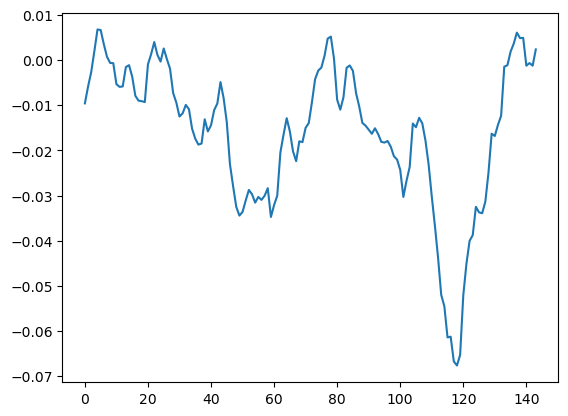

In [137]:
with torch.no_grad():
    # shift train predictions for plotting
    y_pred = model(X_train)
    y_pred = y_pred
    # shift test predictions for plotting
plt.plot(y_pred)
    


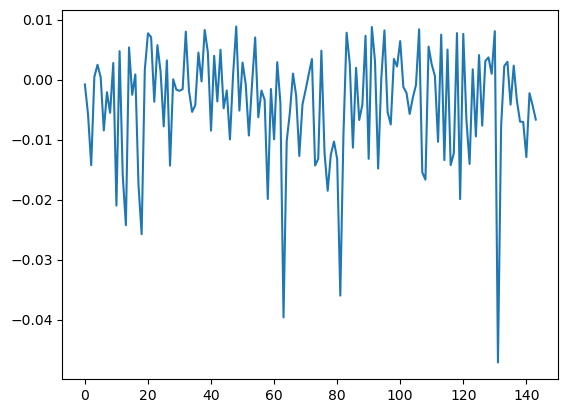

In [138]:
noise = np.random.weibull(150, len(y_pred)) - 1.0
plt.plot(noise)

In [139]:
noised = y_pred[:,0] + noise


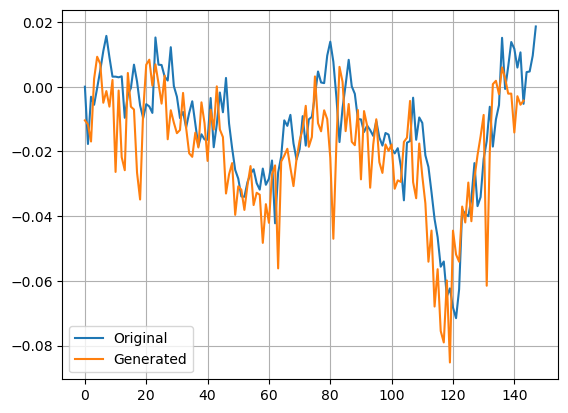

In [140]:
plt.plot(road_profile_0['Z'], label='Original')
plt.plot(noised, label='Generated')
plt.legend()
plt.grid()

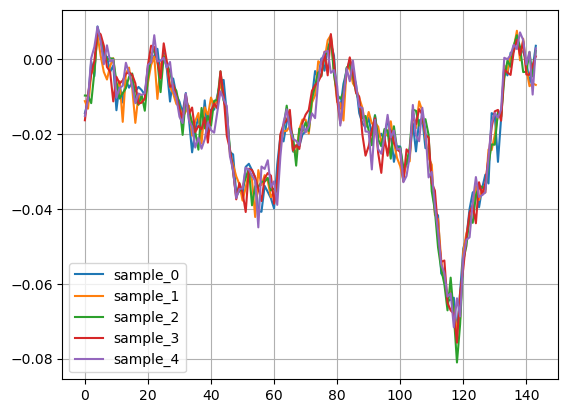

In [141]:
CNT_SAMPLES = 5
samples = []
for _ in range(CNT_SAMPLES):
    with torch.no_grad():
        # shift train predictions for plotting
        noise = np.random.weibull(250, (len(X_train), 4)) - 1.0
        y_pred = model(X_train + torch.Tensor(noise))
        y_pred = y_pred
        samples.append(y_pred)
        # shift test predictions for plotting
for i, s in enumerate(samples):
    plt.plot(s[:, 0], label=f"sample_{i}")
    plt.legend()
    plt.grid()

In [142]:
noise

array([[-3.61396465e-03, -2.02463288e-02,  1.75864654e-03,
        -3.04743739e-03],
       [ 4.65887701e-03, -1.98238040e-03,  1.85842527e-03,
        -1.26539118e-02],
       [ 1.11564482e-03,  5.44789375e-03,  9.48380036e-04,
         3.90141782e-03],
       [-2.35174059e-03,  9.17034192e-04, -2.28071204e-05,
         2.86279453e-03],
       [-3.52525531e-03, -2.19533669e-03,  2.62030492e-03,
         3.72349696e-03],
       [-1.79788407e-02,  1.71915249e-03, -3.57533976e-03,
        -2.43759848e-03],
       [-7.89643388e-03, -4.95278910e-03, -3.63300747e-03,
        -7.52806001e-03],
       [-2.45690029e-03,  3.32035248e-03,  8.14740797e-03,
         3.25439472e-04],
       [-5.20145768e-03, -4.52614684e-03, -1.26069577e-03,
         3.54405215e-03],
       [-2.93246654e-03, -1.51085035e-03,  2.34601250e-03,
         6.86624817e-04],
       [-7.24819883e-03, -4.66512330e-03,  2.33834257e-03,
        -1.13895067e-02],
       [-9.81304298e-05, -7.47632653e-04, -3.16417246e-03,
      

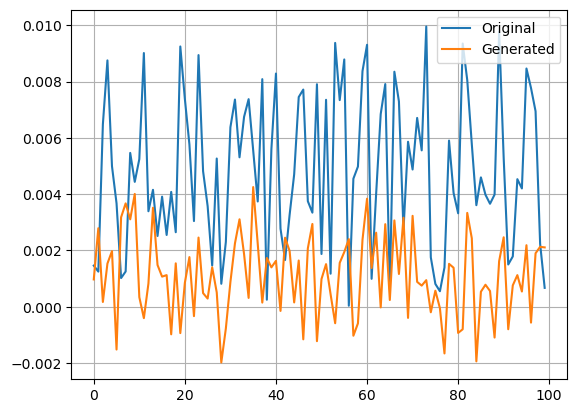

In [143]:
dist = 0.01*torch.rand((100, 4))
with torch.no_grad():
    # shift train predictions for plotting
    y_pred = model(dist)
    y_pred = y_pred
    # shift test predictions for plotting

plt.plot(dist[:,0], label='Original')
plt.plot(y_pred, label='Generated')
plt.legend()
plt.grid()

In [144]:
road_profile_0['Z']

0      0.0000
1     -0.0177
2     -0.0031
3     -0.0056
4     -0.0004
        ...  
143   -0.0053
144    0.0045
145    0.0047
146    0.0096
147    0.0186
Name: Z, Length: 148, dtype: float64

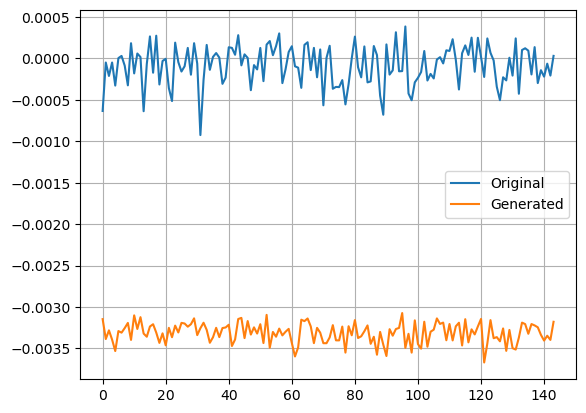

In [153]:
n = np.random.weibull(50, (len(X_train), 4)) - 1.0
n = n + 0.001*np.random.normal(0.1, 0.1, (len(X_train), 4))
dist = 0.01*torch.Tensor(n)
with torch.no_grad():
    # shift train predictions for plotting
    y_pred = model(dist)
    y_pred = y_pred
    # shift test predictions for plotting

plt.plot(dist[:,0], label='Original')
plt.plot(y_pred, label='Generated')
plt.legend()
plt.grid()